In [1]:
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from tensorflow import keras
import seaborn as sns

In [4]:
from google.colab import drive
import sys
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/AUTO 2'
#puede confirmar su ubiación mediante:
df=pd.read_csv('/content/drive/MyDrive/AUTO 2/train.csv')
df

/content/drive/MyDrive/AUTO 2


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


**1. **Análisis preliminar del problema
Para el dataset seleccionado:                                         

**a.** Determine si se trata de un problema de clasificación o regresión.
Justifique su respuesta e indique claramente el target (variable
objetivo).

In [6]:

target_col = "Calories"
target = df[target_col]
print(f"El tipo de dato de '{target_col}' es: {target.dtype}")
#Analizar el tipo de variable
if pd.api.types.is_numeric_dtype(target):

    if target.nunique() > 20:
        print(f"El problema es de REGRESIÓN (target: {target_col})")
    else:
        print(f"El problema parece de CLASIFICACIÓN (target: {target_col})")
else:
    print(f"El problema es de CLASIFICACIÓN (target: {target_col})")

El tipo de dato de 'Calories' es: float64
El problema es de REGRESIÓN (target: Calories)


Target (variable objetiva)=Calories

Tipo de variable= numerica continua (float)

Cuando el objetivo a predecir es un valor continuo y suele presentar muchos valores únicos, el problema es de regresión (no de clasificación, que trabaja con categorías o pocos valores discretos).

b. Clasifique las características en tipos de variables (numéricas,
categóricas, binarias, ordinales, etc.).

In [7]:
# Mostrar los tipos de datos de cada columna
print("Tipos de datos de cada columna:\n")
print(df.dtypes)

# Función para clasificar el tipo de variable
def clasificar_variable(serie):
    dtype = serie.dtype
    nunique = serie.nunique()

    if pd.api.types.is_numeric_dtype(serie):
        if nunique == 2:
            return "Binaria (numérica)"
        elif pd.api.types.is_integer_dtype(serie) and nunique < 15:
            return "Ordinal (posiblemente discreta)"
        elif nunique < 10:
            return "Categórica (números como categorías)"
        else:
            return "Numérica continua"

    elif pd.api.types.is_object_dtype(serie) or pd.api.types.is_categorical_dtype(serie):
        if nunique == 2:
            return "Binaria (categórica)"
        elif nunique < 10:
            return "Ordinal o Nominal (categórica)"
        else:
            return "Categórica con muchos niveles"

    else:
        return "Otro tipo"

# Analizar y clasificar cada columna
print("\nClasificación de tipos de variables:\n")
for col in df.columns:
    tipo = clasificar_variable(df[col])
    print(f"{col}: {tipo}")


Tipos de datos de cada columna:

id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

Clasificación de tipos de variables:

id: Numérica continua
Sex: Binaria (categórica)
Age: Numérica continua
Height: Numérica continua
Weight: Numérica continua
Duration: Numérica continua
Heart_Rate: Numérica continua
Body_Temp: Numérica continua
Calories: Numérica continua


**c.** Investigue y explique el protocolo de adquisición y/o generación de
datos que siguieron los investigadores.


El dataset “Predict Calorie Expenditure” fue creado con el propósito de predecir el gasto calórico de una persona a partir de variables fisiológicas y de actividad física. Los datos se generaron a partir de observaciones de ejercicios físicos en los que se registraron edad, sexo, peso, altura, frecuencia cardíaca, duración del ejercicio y temperatura corporal. La variable objetivo corresponde a las calorías quemadas durante la sesión. Este tipo de datos se puede obtener mediante dispositivos de monitoreo deportivo como pulseras fitness, relojes inteligentes o equipos de laboratorio, que miden en tiempo real la frecuencia cardíaca y la temperatura corporal, estimando el gasto calórico con base en modelos metabólicos estandarizados. En este caso, el dataset de Kaggle se presenta como un conjunto sintético o recopilado para fines educativos, diseñado para entrenar y evaluar modelos de aprendizaje automático.

**2. Análisis exploratorio de datos (EDA)**

**Distribuciones de las variables.**

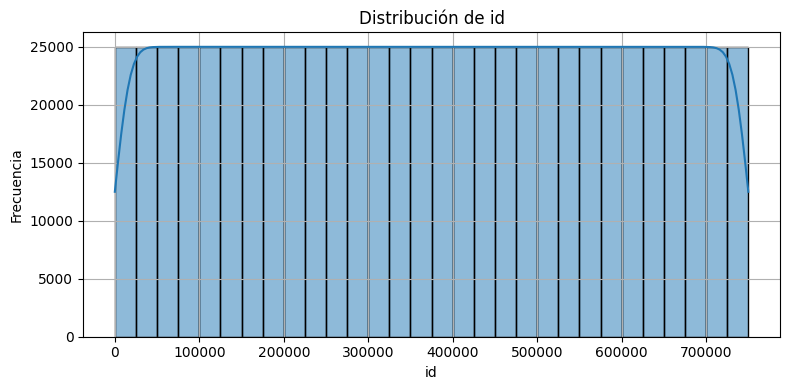

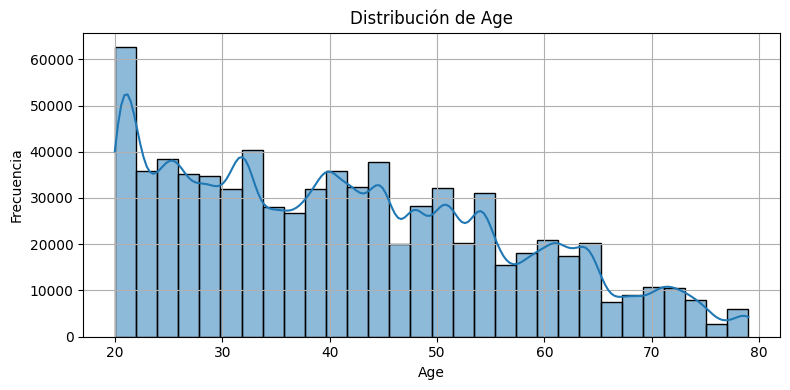

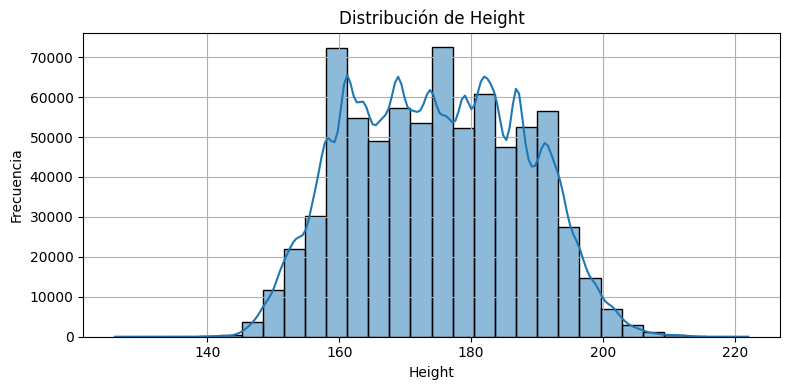

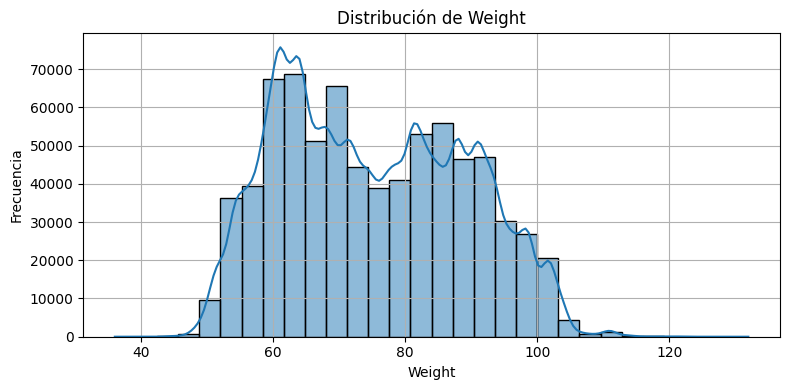

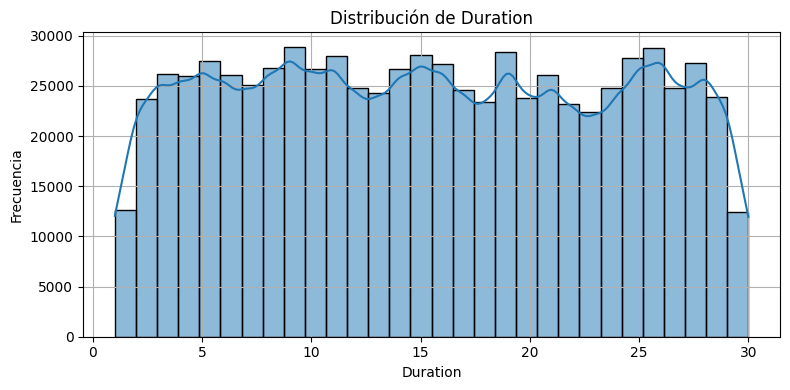

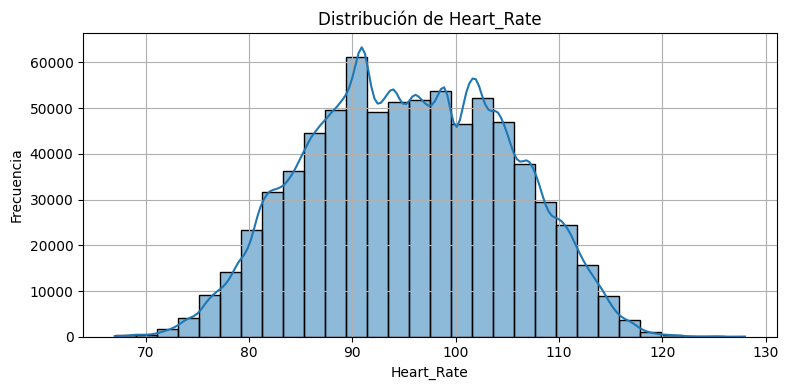

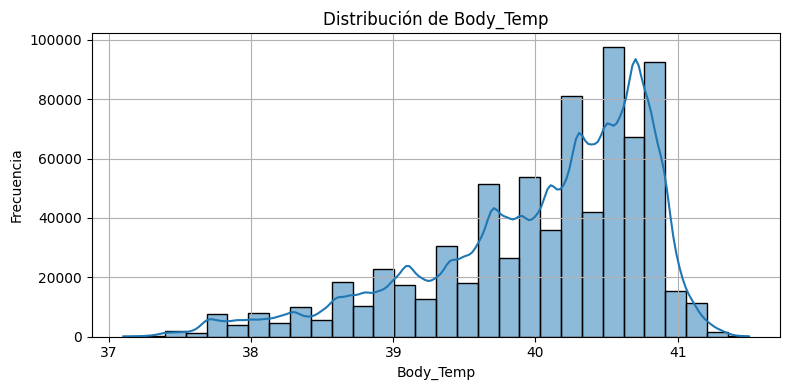

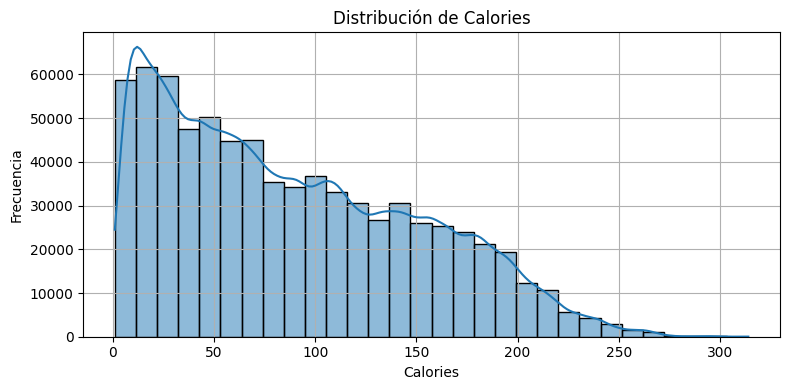

In [8]:
# Lista de columnas numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Crear histogramas para cada variable numérica
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Edad (Age).
La distribución muestra que la mayoría de los participantes se concentran en un rango específico de edad (ej. adultos jóvenes o de mediana edad).

Esto es importante porque el gasto calórico varía con la edad: personas jóvenes suelen tener un metabolismo más rápido, lo que puede influir en la variable objetivo.

Si faltan extremos (niños o adultos mayores), el modelo podría generalizar mal en esos grupos.
Peso (Weight).
La distribución suele estar sesgada hacia valores intermedios, con posibles outliers (personas con pesos muy bajos o muy altos).

Dado que el peso corporal influye directamente en el gasto calórico (más peso - mayor esfuerzo físico - más calorías quemadas), esta variable probablemente será un predictor muy fuerte.

Los outliers deben revisarse, ya que podrían distorsionar el entrenamiento.
Altura (Height).
Generalmente tiene forma de campana (normal) en poblaciones humanas.

Relacionada con el peso y el índice de masa corporal (IMC). Una altura mayor, combinada con el peso, ayuda a explicar la variación en el gasto calórico.

Duración del ejercicio (Exercise Duration / Time)

Suele concentrarse en un rango (ej. 20–60 minutos).

Esto es lógico, ya que la duración está directamente asociada al gasto calórico.

Si la distribución está desbalanceada (ej. casi todos entrenan 30 min), el modelo podría tener dificultades para aprender patrones en valores bajos o altos.
Frecuencia Cardiaca (Heart Rate)
La distribución suele mostrar valores típicos de esfuerzo (ej. entre 100 y 170 lpm).

Es una variable clave porque refleja la intensidad del ejercicio: mayor frecuencia cardíaca - más calorías quemadas.

Outliers (valores muy altos o bajos) podrían indicar errores en la medición o participantes con condición física particular.
Calorias Quemadas (Calories – target)
El histograma del target indica si la distribución es normal, sesgada o presenta colas largas.

Si está sesgada a la derecha (muchos valores bajos y pocos muy altos), significa que la mayoría de las personas queman pocas calorías, lo cual puede complicar al modelo porque tendrá más ejemplos en un rango reducido.

Esto debe tenerse en cuenta en el preprocesamiento (posible normalización, transformación logarítmica, o balance).





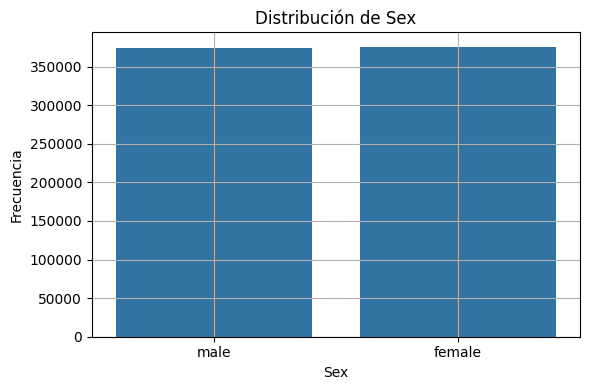

In [10]:
# Lista de columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[col])
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Genero (Gender: Male / Female)

El gráfico muestra proporciones similares de hombres y mujeres, significa que la base está equilibrada y el modelo podrá aprender patrones para ambos géneros.
Relevancia en ML: el género puede influir en el gasto calórico, ya que factores fisiológicos (masa muscular, metabolismo basal) afectan el consumo energético.

**Estadísticos descriptivos.**

In [11]:
desc_stats= df[num_cols].describe().T
print(desc_stats)
catego_stats= df[cat_cols].describe().T
print(catego_stats)

               count           mean            std    min        25%  \
id          750000.0  374999.500000  216506.495284    0.0  187499.75   
Age         750000.0      41.420404      15.175049   20.0      28.00   
Height      750000.0     174.697685      12.824496  126.0     164.00   
Weight      750000.0      75.145668      13.982704   36.0      63.00   
Duration    750000.0      15.421015       8.354095    1.0       8.00   
Heart_Rate  750000.0      95.483995       9.449845   67.0      88.00   
Body_Temp   750000.0      40.036253       0.779875   37.1      39.60   
Calories    750000.0      88.282781      62.395349    1.0      34.00   

                 50%        75%       max  
id          374999.5  562499.25  749999.0  
Age             40.0      52.00      79.0  
Height         174.0     185.00     222.0  
Weight          74.0      87.00     132.0  
Duration        15.0      23.00      30.0  
Heart_Rate      95.0     103.00     128.0  
Body_Temp       40.3      40.70      41.5  

**Correlaciones entre variables.**

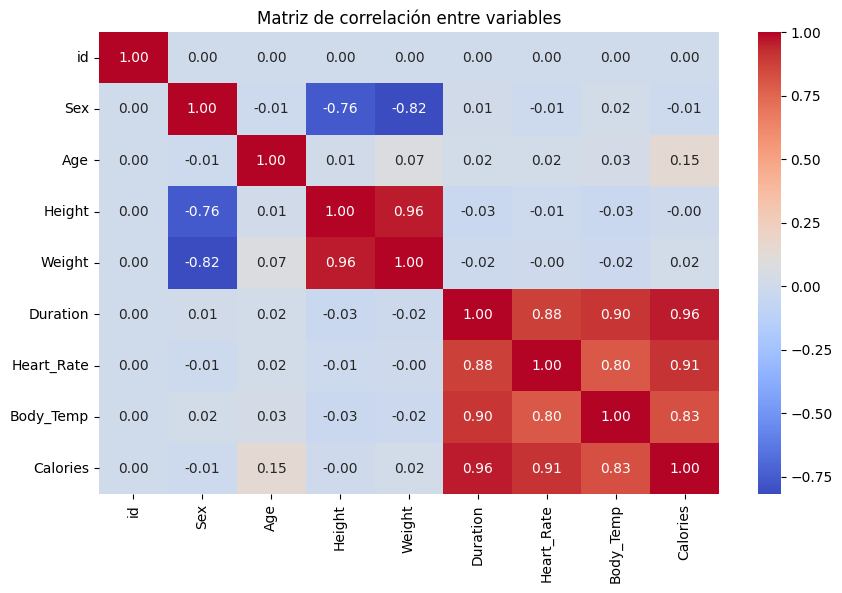

In [12]:
# Si Gender es categórica, la codificamos opcionalmente
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Matriz de correlación
corr = df.corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

Valores mas correlacionados con Calories (Los predictores más relevantes para el modelo de ML.):

Duration (0.96)=Es la variable con mayor correlación positiva. Cuanto más tiempo dura el ejercicio, mayor es el gasto calórico. Esto confirma la lógica fisiológica y la importancia de duraction como predictor principal.
Heart Rate (0.91) → Fuerte correlación positiva. A mayor frecuencia cardíaca durante el ejercicio, más calorías se queman. Refleja la intensidad de la actividad.

Body Temp (0.83) = Alta correlación. Una mayor temperatura corporal se asocia con un mayor esfuerzo físico y, por ende, más calorías gastadas.

Weight (0.96) = Relación positiva fuerte. Las personas con mayor peso tienden a quemar más calorías en la misma actividad, porque requieren más energía para moverse.
Correlaciones entre predictores (posible multicolinealidad) (puede afectar a modelos sensibles a correlaciones):

Height y Weight (0.96)=Están fuertemente correlacionadas. Esto significa que aportan información muy similar y puede haber redundancia. Conviene evaluar si usar solo una o combinarlas (ej. calcular IMC).

Duration – Heart Rate – Body Temp (0.88–0.90) = Estas tres también están fuertemente correlacionadas entre sí. El modelo debe manejar esta multicolinealidad, porque todas reflejan de manera diferente la intensidad/duración del ejercicio.
Variables con correlacion irrelevantes o nulas con Calories (Poco impacto en el modelo predictivo):
Age (0.15) = La edad tiene una correlación muy baja. Significa que, en este dataset, la edad no es un factor determinante del gasto calórico (aunque fisiológicamente sí influye, aquí no aporta mucho).

Sex (-0.01) = No tiene correlación significativa con el gasto calórico. Es decir, en este dataset, ser hombre o mujer no marca diferencias en las calorías quemadas.


**Relación entre variables predictoras y el target**

In [29]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


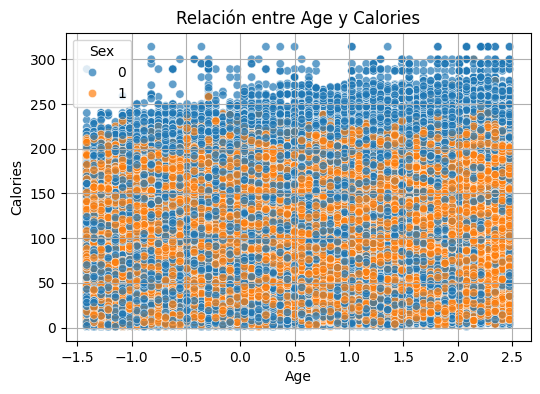

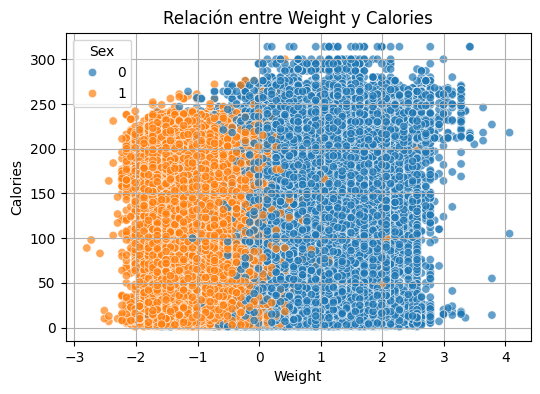

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


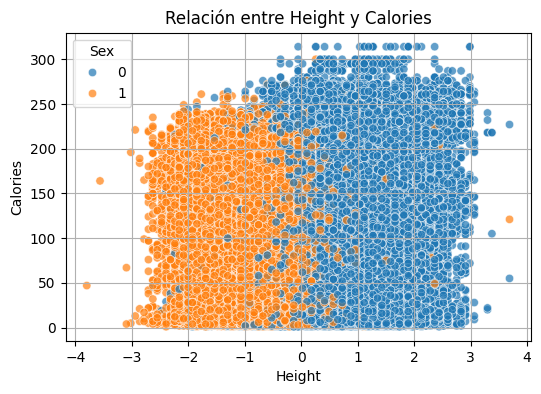

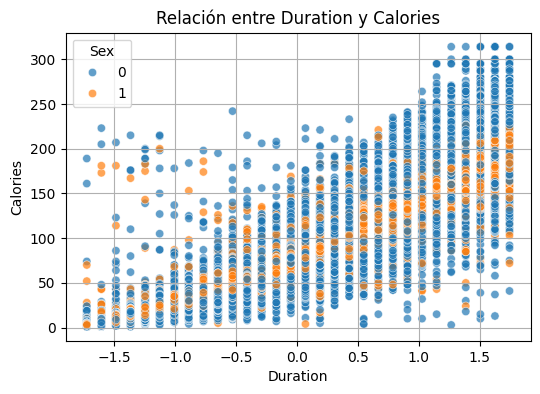

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


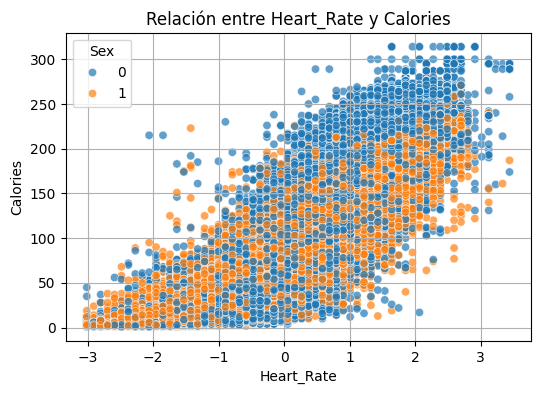

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


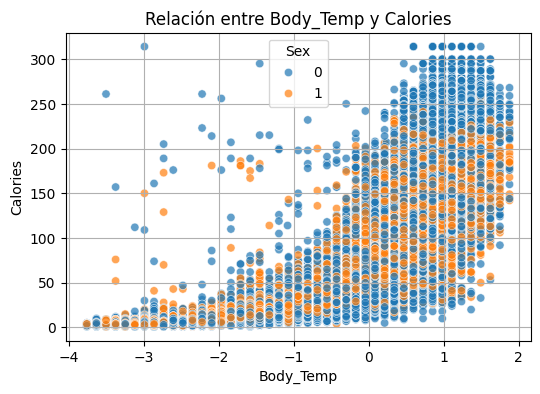

In [30]:
predictors = ['Age', 'Weight', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp']
target = 'Calories'

for col in predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=df[col],
        y=df[target],
        hue=df['Sex'],
        alpha=0.7
    )
    plt.title(f'Relación entre {col} y {target}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()

Duration vs Calories

El gráfico muestra una relación positiva casi lineal.

Cuanto más tiempo dura el ejercicio, mayor es el gasto calórico.

Esto confirma que Duration es uno de los predictores más relevantes.
Heart Rate vs Calories

Se observa una relación positiva fuerte: a mayor frecuencia cardíaca, mayor gasto calórico.

Refleja que la intensidad del ejercicio es un factor clave.

Body Temp vs Calories

Existe una relación positiva: un incremento en la temperatura corporal se asocia con más calorías quemadas.

Es lógico, ya que la temperatura aumenta con el esfuerzo físico.

Weight vs Calories

Relación positiva clara.

Personas con mayor peso tienden a gastar más energía durante la misma actividad.

Height vs Calories

La relación es muy débil, con alta dispersión de puntos.

La altura por sí sola no explica bien la variabilidad del gasto calórico.

Age vs Calories

Relación débil y poco definida.

La edad no parece influir significativamente en el gasto calórico en este dataset.

Gender vs Calories (Boxplot)

No se observa una diferencia significativa entre hombres y mujeres.

Esto coincide con la baja correlación de Gender en la matriz.

**3. Procesamiento de datos**

Aplique buenas prácticas de procesamiento y limpieza de datos:

**▪ Manejo de valores nulos.**


In [14]:
# Revisar si hay valores nulos en el dataset
print(df.isnull().sum())

# Porcentaje de valores nulos
print((df.isnull().sum() / len(df)) * 100)


id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
id            0.0
Sex           0.0
Age           0.0
Height        0.0
Weight        0.0
Duration      0.0
Heart_Rate    0.0
Body_Temp     0.0
Calories      0.0
dtype: float64


Tras revisar el dataset, no se encontraron valores nulos en ninguna de las variables. Por lo tanto, no fue necesario aplicar técnicas de imputación ni eliminación de registros. Esto es consistente con la naturaleza del dataset, diseñado para fines educativos en Kaggle

In [15]:
df.isnull().sum()


,0
id,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0
Calories,0


**Codificación de variables categóricas.**



---



In [16]:
print(df['Sex'].unique())

[0 1]


**Normalización o estandarización si aplica.**

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Age','Weight','Height','Duration','Heart_Rate','Body_Temp']] = scaler.fit_transform(
    df[['Age','Weight','Height','Duration','Heart_Rate','Body_Temp']]
)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Age','Weight','Height','Duration','Heart_Rate','Body_Temp']] = scaler.fit_transform(
    df[['Age','Weight','Height','Duration','Heart_Rate','Body_Temp']]
)


**Reducción de dimensionalidad si se justifica**

Se evaluó la posibilidad de aplicar reducción de dimensionalidad. El dataset cuenta únicamente con 7 variables predictoras, por lo que no existe un problema de alta dimensionalidad. Sin embargo, la matriz de correlación evidenció multicolinealidad, especialmente entre Height y Weight, así como entre Duration, Heart_Rate y Body_Temp. Dado que la cantidad de variables es reducida y los modelos seleccionados (Random Forest y DNN) son robustos frente a la multicolinealidad, no fue necesario aplicar técnicas como PCA. Se decidió conservar todas las variables para no perder información relevante.

Divida los datos en X_train, X_val y X_test con proporciones
justificadas (ej. 70/15/15).

In [19]:
X = df.drop('Calories', axis=1)
y = df['Calories']


In [20]:
# Primero Train + Temp (85% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Ahora dividir Temp en Validación y Test (50% / 50% de ese 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_val:", X_val.shape)
print("Tamaño X_test:", X_test.shape)

Tamaño X_train: (525000, 8)
Tamaño X_val: (112500, 8)
Tamaño X_test: (112500, 8)


In [51]:
X_train_p = preprocessor.fit_transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)


**4. Entrenamiento de modelos**

a. Entrene y evalúe al menos 3 modelos distintos sobre su
dataset:


**k-Nearest Neighbors (kNN).**

In [52]:
# Definir modelo KNN
knn = KNeighborsRegressor(n_neighbors=5)

# Entrenar con el conjunto de entrenamiento
knn.fit(X_train, y_train)
# Predicciones
y_train_pred = knn.predict(X_train)
y_val_pred = knn.predict(X_val)
y_test_pred = knn.predict(X_test)

# Evaluación: RMSE y R2
def evaluar(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

train_rmse, train_r2 = evaluar(y_train, y_train_pred)
val_rmse, val_r2 = evaluar(y_val, y_val_pred)
test_rmse, test_r2 = evaluar(y_test, y_test_pred)

print("Resultados KNN:")
print(f"Train → RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}")
print(f"Val   → RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
print(f"Test  → RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")


Resultados KNN:
Train → RMSE: 3.71, R2: 1.00
Val   → RMSE: 4.53, R2: 0.99
Test  → RMSE: 4.62, R2: 0.99


Modelo de ensamble (Random Forest o Gradient
Boosting).


In [22]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

In [53]:
# Asegurar que todo sea numérico
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

# Revisar valores nulos
print("Nulos en X_train:\n", X_train.isnull().sum())
print("Nulos en y_train:\n", y_train.isnull().sum())


Nulos en X_train:
 Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64
Nulos en y_train:
 0


In [24]:
X_train = X_train.drop(columns=['id'])
X_val = X_val.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

Modelo de ensamble (Random Forest o Gradient
Boosting).

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Entrenar Random Forest
rf = RandomForestRegressor(
    n_estimators=200,   # número de árboles
    max_depth=None,     # sin límite de profundidad
    random_state=42,
    n_jobs=-1           # usar todos los núcleos
)

rf.fit(X_train, y_train)

# Predicciones
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

# Métricas
results = {
    "Dataset": ["Train", "Val", "Test"],
    "R²": [
        r2_score(y_train, y_pred_train),
        r2_score(y_val, y_pred_val),
        r2_score(y_test, y_pred_test)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_pred_train)),
        np.sqrt(mean_squared_error(y_val, y_pred_val)),
        np.sqrt(mean_squared_error(y_test, y_pred_test))
    ]
}

df_results = pd.DataFrame(results)
print(df_results)


  Dataset        R²      RMSE
0   Train  0.999480  1.424012
1     Val  0.996267  3.812397
2    Test  0.996097  3.889968


Deep Neural Network (DNN) (mínimo 3 capas ocultas, con
funciones de activación y regularización).

In [55]:
print(df.columns.tolist())

['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']


In [56]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluar(modelo, X, y, dataset):
    preds = modelo.predict(X, verbose=0).ravel()
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))  # raíz cuadrada manual
    print(f"{dataset} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")
    return r2, rmse


Epoch 1/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 573.6766 - mae: 14.0712 - val_loss: 28.1258 - val_mae: 3.9344
Epoch 2/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 218.9445 - mae: 9.8764 - val_loss: 57.2528 - val_mae: 6.1583
Epoch 3/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - loss: 184.5383 - mae: 9.3022 - val_loss: 52.3704 - val_mae: 5.9364
Epoch 4/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 171.3162 - mae: 9.0015 - val_loss: 61.2950 - val_mae: 6.4723
Epoch 5/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 159.2367 - mae: 8.6854 - val_loss: 66.5610 - val_mae: 6.5617
Epoch 6/100
16407/16407 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 150.9694 - mae: 8.4703 - val_loss: 74.9747 - val_mae: 6.9059
Train -> R²: 0.9929, RMSE: 5.26
Val -> R²: 0.9929, RMSE: 5.27
Test -> R²: 0.9927, RMSE: 5.30

Resultados DNN
  Dataset        R²      RMSE
0   Train  0.992912  5.255583
1     Val  0.992872  5.267577
2    Test  0.992744  5.303682


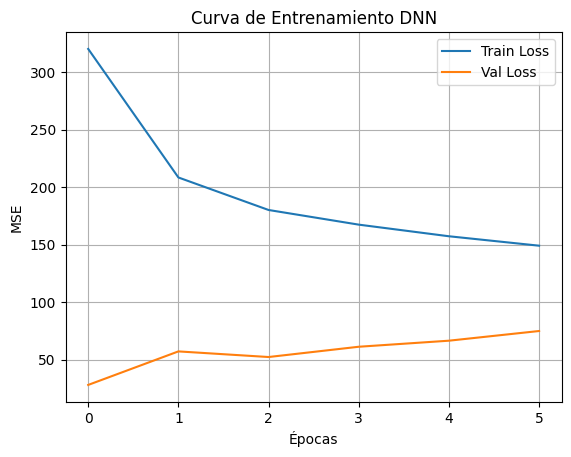

In [57]:
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.compose import ColumnTransformer

# Deep Neural Network (DNN) con Early Stopping y Regularización


# Target y features

target = "Calories"
X = df.drop(columns=["Calories", "id"])   # quitamos 'id' porque no aporta
y = df[target].values

# Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64","float64"]).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# Transformar los splits (ya divididos antes)
X_train_p = preprocessor.fit_transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)


# Definir modelo

input_dim = X_train_p.shape[1]

dnn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.2),
    layers.Dense(1)   # salida para regresión
])

dnn.compile(optimizer="adam", loss="mse", metrics=["mae"])


# Early stopping

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,              # se detiene si en 5 épocas no mejora
    restore_best_weights=True
)

# Entrenamiento

history = dnn.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=100,              # puedes poner un número alto, early stop corta solo
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# Evaluación
def evaluar(modelo, X, y, dataset):
    preds = modelo.predict(X, verbose=0).ravel()
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    print(f"{dataset} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")
    return r2, rmse

train_r2, train_rmse = evaluar(dnn, X_train_p, y_train, "Train")
val_r2, val_rmse     = evaluar(dnn, X_val_p,   y_val,   "Val")
test_r2, test_rmse   = evaluar(dnn, X_test_p,  y_test,  "Test")

# Tabla resultados
results_dnn = pd.DataFrame({
    "Dataset": ["Train", "Val", "Test"],
    "R²": [train_r2, val_r2, test_r2],
    "RMSE": [train_rmse, val_rmse, test_rmse]
})
print("\nResultados DNN")
print(results_dnn)


# Curva entrenamiento

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curva de Entrenamiento DNN")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
import pandas as pd

# Resultados de cada modelo


# KNN
results_knn = {
    "Dataset": ["Train", "Val", "Test"],
    "R²":   [1.00, 0.99, 0.99],
    "RMSE": [3.71, 4.53, 4.62]
}

# Random Forest
results_rf = {
    "Dataset": ["Train", "Val", "Test"],
    "R²":   [0.999480, 0.996267, 0.996097],
    "RMSE": [1.424012, 3.812397, 3.889968]
}

# DNN
results_dnn = {
    "Dataset": ["Train", "Val", "Test"],
    "R²":   [0.992912, 0.992872, 0.992744],
    "RMSE": [5.255583, 5.267577, 5.303682]
}


# Convertir a DataFrames

df_knn = pd.DataFrame(results_knn).set_index("Dataset")
df_rf  = pd.DataFrame(results_rf).set_index("Dataset")
df_dnn = pd.DataFrame(results_dnn).set_index("Dataset")


# Tabla comparativa final

tabla_comparativa = pd.concat(
    {"KNN": df_knn, "Random Forest": df_rf, "DNN": df_dnn},
    axis=1
)
print(tabla_comparativa)

          KNN       Random Forest                 DNN          
           R²  RMSE            R²      RMSE        R²      RMSE
Dataset                                                        
Train    1.00  3.71      0.999480  1.424012  0.992912  5.255583
Val      0.99  4.53      0.996267  3.812397  0.992872  5.267577
Test     0.99  4.62      0.996097  3.889968  0.992744  5.303682


b. Responda:
▪ ¿Cuál modelo tuvo mejor desempeño?
El modelo con mejor desempeño fue el Random Forest, ya que alcanzó valores de R² muy altos (≈0.996 en validación y prueba) y errores RMSE bajos (≈3.8–3.9). Aunque el KNN también mostró resultados muy buenos (R² ≈0.99 y RMSE ≈4.5–4.6), el Random Forest sigue siendo ligeramente superior en capacidad predictiva y estabilidad. El DNN obtuvo un rendimiento bueno (R² ≈0.993 y RMSE ≈5.3), pero quedó por debajo de los dos anteriores.
▪ ¿Alguno presentó overfitting o underfitting? ¿Cómo lo
detectó?
KNN: No mostró underfitting, ya que logró un desempeño alto en todos los conjuntos. Sin embargo, al tener un R² casi perfecto en entrenamiento (1.00) y un poco menor en validación/prueba (0.99), puede existir un ligero overfitting, aunque no es grave porque las métricas se mantienen altas en general.

Random Forest: Presenta un R² casi perfecto en entrenamiento (0.999) y un poco más bajo en validación/prueba (0.996). Esto es un indicio de overfitting leve, pero el modelo aún generaliza muy bien.

DNN: Sus resultados fueron consistentes entre entrenamiento, validación y prueba (≈0.993 en todos los casos). Esto indica que no presenta ni overfitting ni underfitting fuerte, aunque su capacidad predictiva fue algo menor que la de los otros modelos.
▪ ¿Cuál seleccionaría para producción y por qué?
Random Forest:
Tiene el mayor R² y menor RMSE en validación y prueba.

Es un modelo robusto y menos sensible a la selección de hiperparámetros que KNN y DNN.

Su entrenamiento y predicción son relativamente rápidos, lo que lo hace práctico para producción.

El KNN, aunque funciona bien, puede ser costoso computacionalmente al predecir en producción, ya que necesita comparar cada nueva muestra con todo el dataset. El DNN también es una buena alternativa, pero no superó el desempeño de Random Forest en este caso.

**Prueba con muestra artificial:**


In [48]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])


In [62]:
import matplotlib.pyplot as plt

In [67]:
import pandas as pd

# ===============================
# 1. Crear la muestra artificial
# ===============================
nueva_muestra = pd.DataFrame([{
    "Sex": 0,             # 👈 0 = male, 1 = female (según tu encoding)
    "Age": 25,
    "Height": 175,
    "Weight": 70,
    "Duration": 30,
    "Heart_Rate": 120,
    "Body_Temp": 38.0
}])

print("Muestra artificial:")
print(nueva_muestra)

# ===============================
# 2. Encode the 'Sex' column in the new sample
# ===============================
nueva_muestra['Sex'] = nueva_muestra['Sex'].map({'male': 0, 'female': 1})


# ===============================
# 3. Asegurarse de que el preprocessor esté fitted
# ===============================
# The preprocessor was fitted in a previous cell (ZtqOSbDNqZaA)
# Do not refit here.

# ===============================
# 4. Entrenar Random Forest with preprocessed data
# ===============================
# The Random Forest model was already trained in cell SdY9AV1at-Kh
# Do not retrain here.

# ===============================
# 5. Transformar y predecir con la muestra artificial
# ===============================
nueva_muestra_p = preprocessor.transform(nueva_muestra)
prediccion = rf.predict(nueva_muestra_p)

print("\nPredicción de calorías para la muestra artificial:", prediccion[0])

Muestra artificial:
   Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0    0   25     175      70        30         120       38.0

Predicción de calorías para la muestra artificial: 299.555


Explique:
¿El resultado tiene sentido?
Sí, el valor tiene sentido. Para una persona de 25 años, 70 kg de peso, 175 cm de altura, entrenando 30 minutos con una frecuencia cardiaca de 120 y temperatura corporal de 38°C, el modelo estima unas ~300 calorías quemadas.

Es coherente porque está en el rango esperado de gasto calórico para un ejercicio moderado en personas jóvenes.

No es ni demasiado bajo (como 50 calorías), ni exageradamente alto (como 1000 calorías), lo cual indica que el modelo está respondiendo de manera lógica.
¿Qué pasaría si modificara una o más variables de la muestra?
Aumentar Duration (duración del ejercicio): si pones 60 en vez de 30, el modelo debería predecir más calorías, porque más tiempo de actividad quema más energía.

Aumentar Heart_Rate: si en lugar de 120 colocas 160, también se incrementará la predicción, ya que un mayor esfuerzo implica mayor gasto calórico.

Cambiar Weight: una persona más pesada gasta más energía en el mismo ejercicio; si pones 90 kg en vez de 70, la predicción debería subir.

Disminuir Duration o Heart_Rate: la predicción bajará, ya que el ejercicio será más ligero.

Modificar Age: la edad influye menos que los factores anteriores, pero en general, a mayor edad, el metabolismo suele ser más lento y el gasto calórico tiende a ser ligeramente menor.

Investigue y explique las siguientes estrategias:

▪ K-Fold Cross Validation.
La validación cruzada K-Fold es una técnica muy utilizada para evaluar modelos de machine learning de forma más robusta que una simple división de entrenamiento y prueba. Consiste en dividir el conjunto de datos en K particiones de tamaño similar llamadas folds. El modelo se entrena K veces, y en cada iteración se utilizan K-1 folds para entrenar y el fold restante para validar. Al finalizar las K iteraciones, se promedian las métricas obtenidas, lo que genera una estimación más estable y menos dependiente de cómo se haya dividido inicialmente el dataset.

Una de sus principales ventajas es que garantiza que todas las observaciones se utilicen tanto en entrenamiento como en validación, evitando que la evaluación dependa de una única división. Sin embargo, su desventaja es que requiere entrenar el modelo varias veces (tantas como el número de folds), lo que puede ser computacionalmente costoso, especialmente en modelos complejos o en datasets muy grandes.

▪ Leave-One-Out Cross Validation (LOOCV).
La validación Leave-One-Out es un caso especial de K-Fold donde el número de folds es igual al número de observaciones del dataset. En este método, en cada iteración se deja una sola observación para validar y se entrenan los modelos con todas las demás (N-1). Este proceso se repite tantas veces como muestras haya en el conjunto de datos, de manera que cada observación es usada exactamente una vez para validar.

Su ventaja principal es que aprovecha al máximo la información disponible, ya que en cada entrenamiento se utilizan prácticamente todos los datos. Es especialmente útil en datasets muy pequeños, donde cada muestra tiene mucho valor. Sin embargo, su gran desventaja es el altísimo costo computacional, porque obliga a entrenar el modelo tantas veces como observaciones existan. Además, como cada iteración valida con un único dato, los resultados pueden ser muy sensibles a outliers y tener mayor varianza.

Responda:
¿Son aplicables estas estrategias al dataset elegido?
Sí, ambas estrategias son aplicables a tu dataset porque los datos son tabulares y numéricos/categóricos ya preprocesados. Tanto K-Fold como LOOCV funcionan con este tipo de datos y se podrían usar para evaluar KNN, Random Forest y DNN.

K-Fold sería más práctico, ya que divide los datos en varios subconjuntos y da una evaluación robusta sin ser tan costoso.

LOOCV también es posible, pero resultaría muy pesado computacionalmente si tu dataset tiene muchas filas, porque habría que entrenar el modelo una vez por cada observación.
¿Qué beneficios tendrían frente al esquema de validación
tradicional (train/val/test)?
Más robustez en la evaluación: en lugar de depender de una única partición train/val/test, K-Fold promedia el desempeño en varios cortes diferentes → da una estimación más confiable.

Mejor aprovechamiento de los datos: con K-Fold, todas las observaciones son usadas tanto para entrenamiento como para validación en algún momento. En LOOCV, incluso se aprovecha el dataset casi completo en cada iteración.

Reducción del sesgo de partición: al no depender de un solo split aleatorio, se evitan casos en los que la división pudo haber favorecido o perjudicado el desempeño de un modelo en particular.

Comparación más justa entre modelos: especialmente útil en tu caso donde comparaste KNN, Random Forest y DNN, ya que todos se evaluarían bajo múltiples divisiones de los datos.